In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import os 
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix




In [3]:

# Define paths
train_dir = 'train'
validation_dir = 'valid'

# Create an ImageDataGenerator instance for training with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,              # Rescale pixel values from [0, 255] to [0, 1]
    rotation_range=40,            # Randomly rotate images
    width_shift_range=0.2,        # Randomly shift images horizontally
    height_shift_range=0.2,       # Randomly shift images vertically
    shear_range=0.2,              # Randomly shear images
    zoom_range=0.2,               # Randomly zoom into images
    horizontal_flip=True,         # Randomly flip images horizontally
    fill_mode='nearest'           # Fill in new pixels after transformation
)

# Create an ImageDataGenerator instance for validation without data augmentation
validation_datagen = ImageDataGenerator(rescale=1.0/255)

# Create training data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,                    # Directory with training images
    target_size=(150, 150),       # Resize images to 150x150 pixels
    batch_size=32,                # Number of images to load at once
    class_mode='categorical'      # For multi-class classification
)

# Create validation data generator
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,               # Directory with validation images
    target_size=(150, 150),       # Resize images to 150x150 pixels
    batch_size=32,                # Number of images to load at once
    class_mode='categorical'      # For multi-class classification
)


Found 3208 images belonging to 20 classes.
Found 100 images belonging to 20 classes.


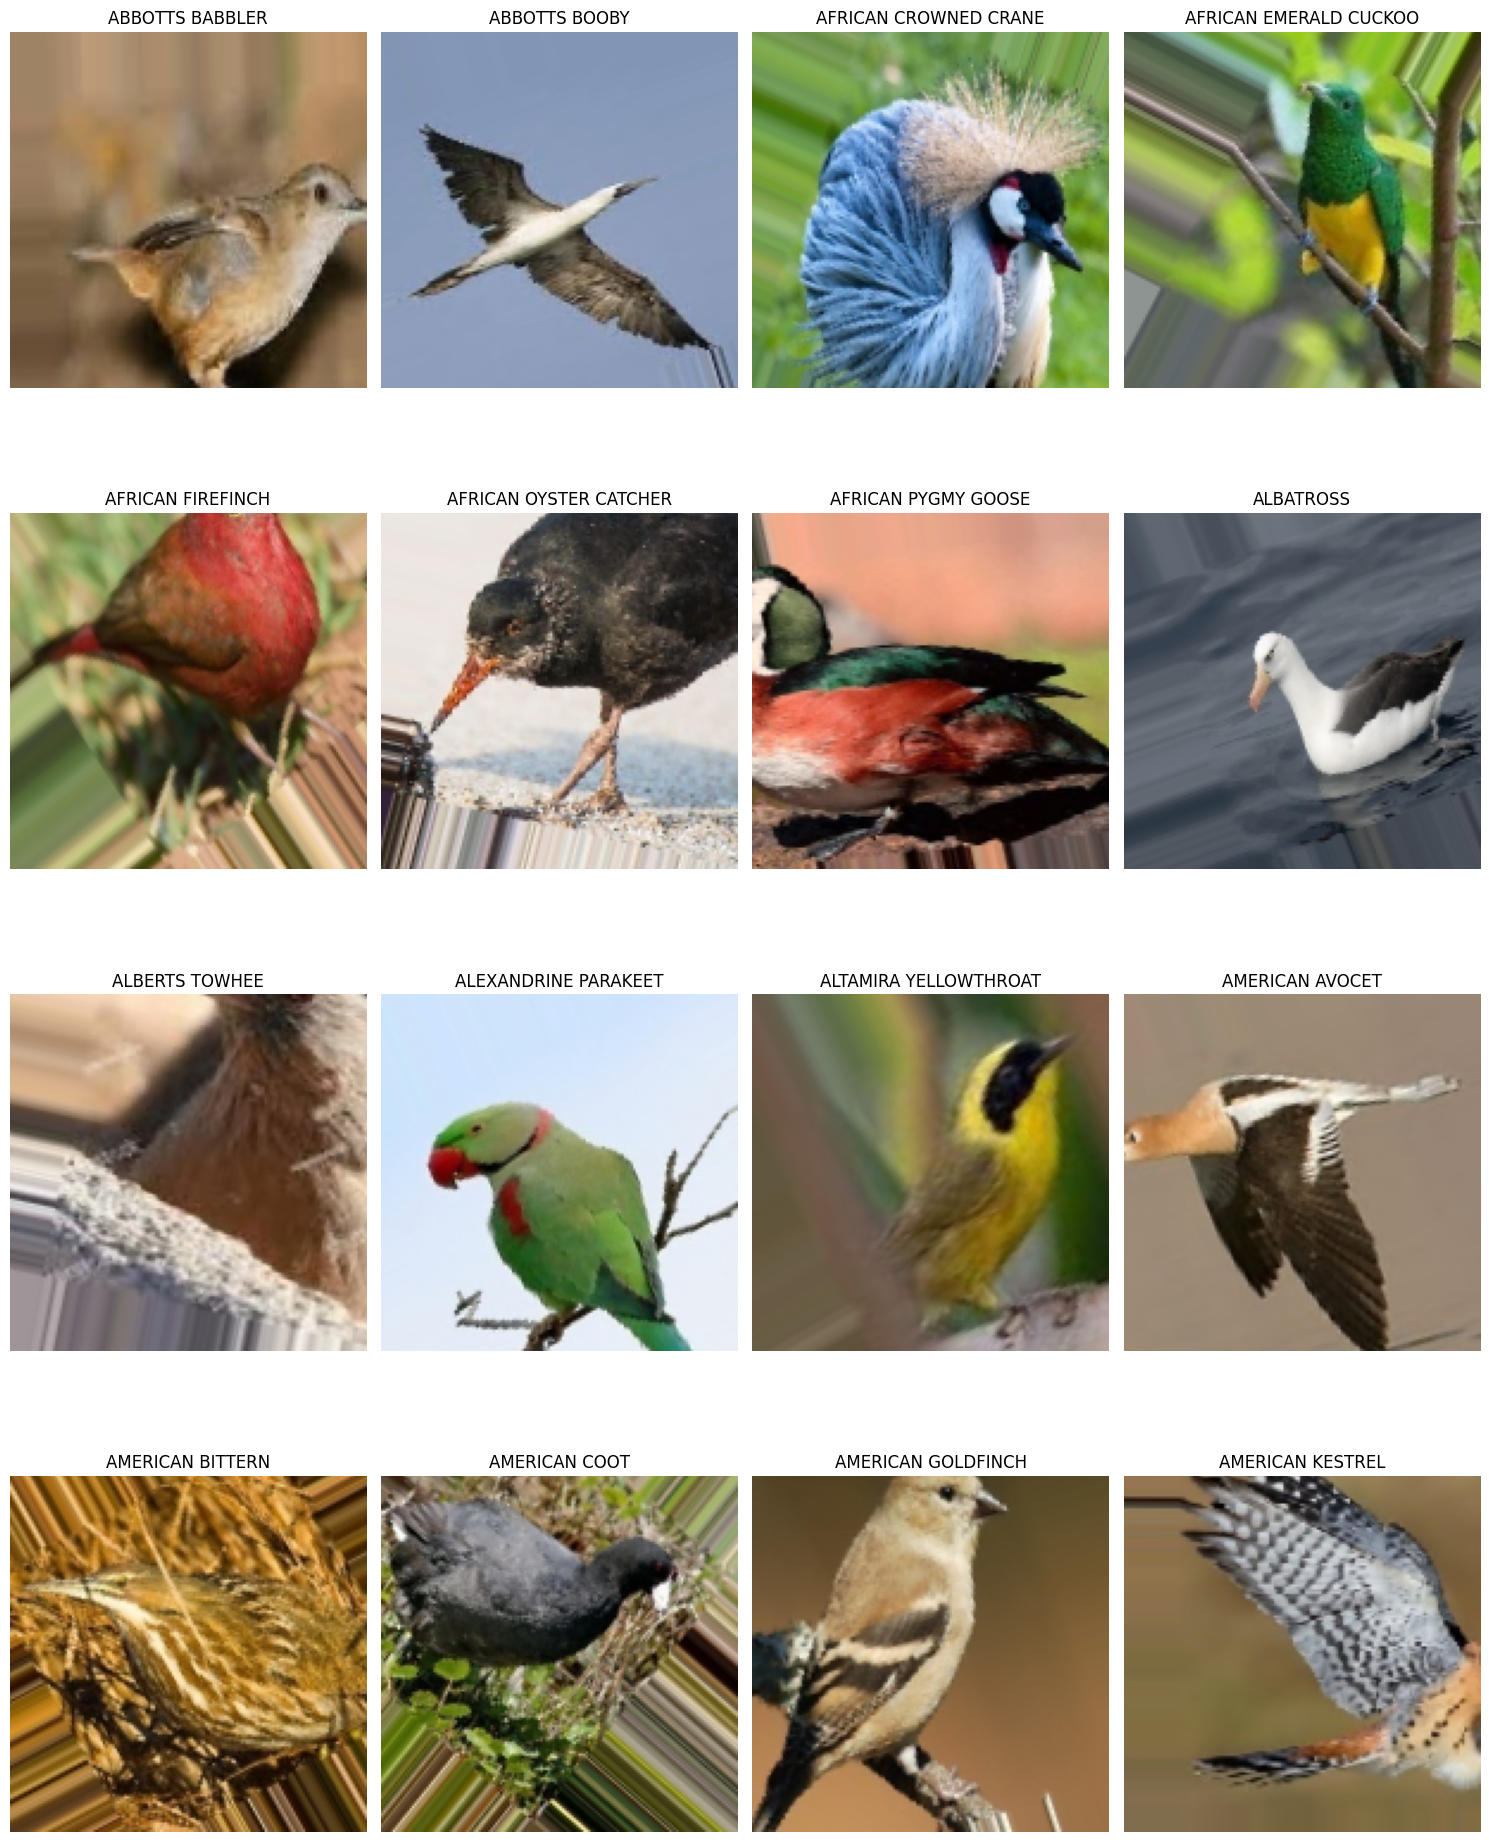

In [4]:


# Get the class labels from the generator
class_labels = train_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}  # Reverse the dictionary to get labels by index

# Load one batch of images and labels
images, labels = next(train_generator)

# Find one image per class
unique_classes = np.unique(np.argmax(labels, axis=1))

# Determine the number of rows needed to display 4 images per row
num_classes = len(unique_classes)
num_cols = 4
num_rows = (num_classes + num_cols - 1) // num_cols  # Ceiling division to get the number of rows

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))

# Plot each image
for idx, class_idx in enumerate(unique_classes):
    row = idx // num_cols
    col = idx % num_cols
    image_idx = np.argmax(np.argmax(labels, axis=1) == class_idx)
    ax = axes[row, col]
    ax.imshow(images[image_idx])
    ax.set_title(class_labels[class_idx])
    ax.axis('off')

# Remove any empty subplots
for idx in range(len(unique_classes), num_rows * num_cols):
    fig.delaxes(axes.flatten()[idx])

plt.tight_layout()

plt.show()


In [5]:


# Initialize lists to hold image paths and labels
image_paths = []
labels = []

# Get the class labels from the generator
class_labels = train_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}  # Reverse the dictionary to get labels by index

# Extract image paths and labels
for class_label, class_name in class_labels.items():
    class_dir = os.path.join(train_dir, class_name)
    for fname in os.listdir(class_dir):
        if fname.endswith(".jpg"):  # Assuming images are in .jpg format
            image_paths.append(os.path.join(class_dir, fname))
            labels.append(class_name)

# Create a DataFrame
data = {'image_path': image_paths, 'label': labels}
df = pd.DataFrame(data)

# Display the head(10) of the DataFrame
df.head(10)


,image_path,label
0,train\ABBOTTS BABBLER\001.jpg,ABBOTTS BABBLER
1,train\ABBOTTS BABBLER\002.jpg,ABBOTTS BABBLER
2,train\ABBOTTS BABBLER\003.jpg,ABBOTTS BABBLER
3,train\ABBOTTS BABBLER\004.jpg,ABBOTTS BABBLER
4,train\ABBOTTS BABBLER\005.jpg,ABBOTTS BABBLER
5,train\ABBOTTS BABBLER\006.jpg,ABBOTTS BABBLER
6,train\ABBOTTS BABBLER\007.jpg,ABBOTTS BABBLER
7,train\ABBOTTS BABBLER\008.jpg,ABBOTTS BABBLER
8,train\ABBOTTS BABBLER\009.jpg,ABBOTTS BABBLER
9,train\ABBOTTS BABBLER\010.jpg,ABBOTTS BABBLER


In [6]:
# Check for null values
print("Checking for null values:\n", df.isnull().sum())

# Drop rows with any null values
df = df.dropna()

# Check for duplicates
print("\nChecking for duplicate rows:\n", df.duplicated().sum())

# Drop duplicate rows
df = df.drop_duplicates()



Checking for null values:
 image_path    0
label         0
dtype: int64

Checking for duplicate rows:
 0


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


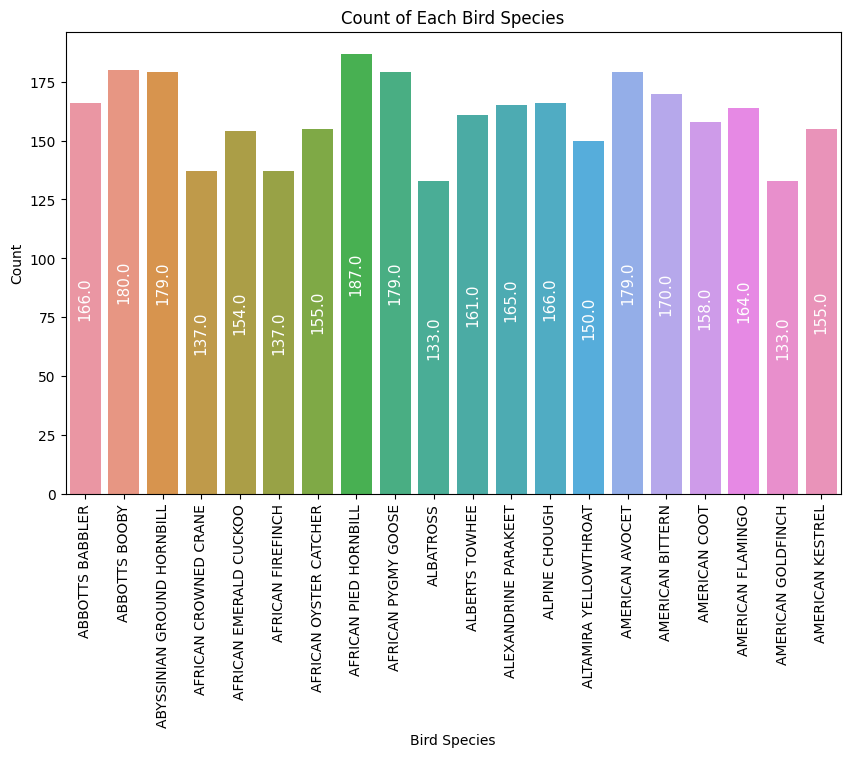

In [7]:


# Create a count plot for the target column
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x='label')
plt.title('Count of Each Bird Species')
plt.xlabel('Bird Species')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x labels for better readability

# Add counts inside each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height() / 2), 
                ha='center', va='center', fontsize=11, color='white', rotation=90)

plt.show()


In [8]:

from tensorflow.keras import layers, models

# Define the CNN model architecture
model = models.Sequential([
    # Convolutional Layer 1
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    
    # Convolutional Layer 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Convolutional Layer 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Convolutional Layer 4
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Flatten the output
    layers.Flatten(),
    
    # Dense Layer 1
    layers.Dense(512, activation='relu'),
    
    # Output Layer
    layers.Dense(len(class_labels), activation='softmax')  # Number of classes
])

# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

In [9]:
# Compile the model
model.compile(
    optimizer='adam',                  # Optimizer
    loss='categorical_crossentropy',   # Loss function for multi-class classification
    metrics=['accuracy']               # Metrics to monitor
)


In [11]:
# Train the model
history = model.fit(
    train_generator,                   # Training data generator
    epochs=30,                         # Number of epochs
    validation_data=validation_generator, # Validation data generator
    verbose=1                          # Verbosity mode
)


Epoch 1/30
101/101 [==============================] - 35s 348ms/step - loss: 0.5748 - accuracy: 0.8080 - val_loss: 0.4030 - val_accuracy: 0.8700
Epoch 2/30
101/101 [==============================] - 37s 361ms/step - loss: 0.5655 - accuracy: 0.8195 - val_loss: 0.5493 - val_accuracy: 0.7800
Epoch 3/30
101/101 [==============================] - 37s 370ms/step - loss: 0.5573 - accuracy: 0.8161 - val_loss: 0.4722 - val_accuracy: 0.8300
Epoch 4/30
101/101 [==============================] - 38s 382ms/step - loss: 0.5649 - accuracy: 0.8145 - val_loss: 0.5664 - val_accuracy: 0.8300
Epoch 5/30
101/101 [==============================] - 39s 383ms/step - loss: 0.5412 - accuracy: 0.8270 - val_loss: 0.5700 - val_accuracy: 0.8100
Epoch 6/30
101/101 [==============================] - 39s 388ms/step - loss: 0.5304 - accuracy: 0.8286 - val_loss: 0.3914 - val_accuracy: 0.8900
Epoch 7/30
101/101 [==============================] - 39s 386ms/step - loss: 0.5094 - accuracy: 0.8301 - val_loss: 0.5731 - val_ac

In [12]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(validation_generator, verbose=1)
print(f'Validation Loss: {val_loss:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')


4/4 [==============================] - 0s 62ms/step - loss: 0.3658 - accuracy: 0.9200
Validation Loss: 0.3658
Validation Accuracy: 0.9200


In [13]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get the true labels from the validation set
true_labels = validation_generator.classes

# Make predictions
predictions = model.predict(validation_generator, verbose=1)

# Get the predicted class indices
predicted_labels = np.argmax(predictions, axis=1)


4/4 [==============================] - 0s 64ms/step


In [14]:
# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)



In [15]:
cm

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
       [0, 1, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
       [0, 0, 0, 2, 0, 0, 0, 0, 0,

4/4 [==============================] - 0s 62ms/step


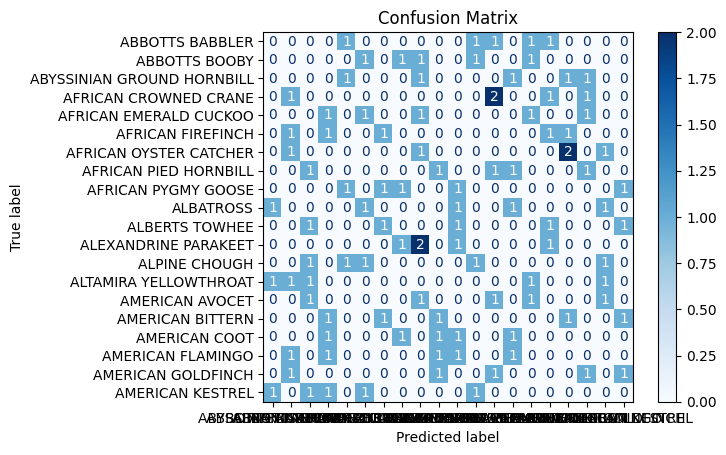

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get true labels
true_labels = validation_generator.classes

# Make predictions
predictions = model.predict(validation_generator, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=validation_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [17]:
model.save('model92.h5')

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


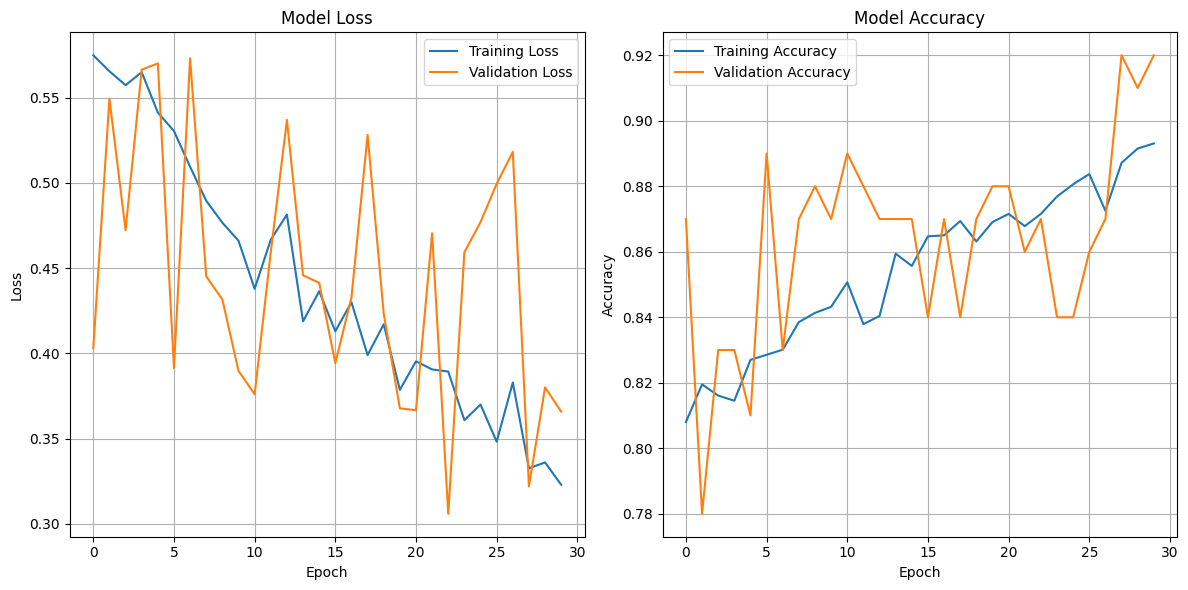

In [18]:


# Check the available metrics
print(history.history.keys())  # Use this to see the available keys

# Plot training & validation loss values
plt.figure(figsize=(12, 6))

# Training Loss
if 'loss' in history.history and 'val_loss' in history.history:
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Training Loss', 'Validation Loss'])
    plt.grid(True)
else:
    print("Loss metrics not found in history.")

# Training Accuracy
if 'accuracy' in history.history and 'val_accuracy' in history.history:
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Training Accuracy', 'Validation Accuracy'])
    plt.grid(True)
else:
    print("Accuracy metrics not found in history.")

plt.tight_layout()
plt.show()


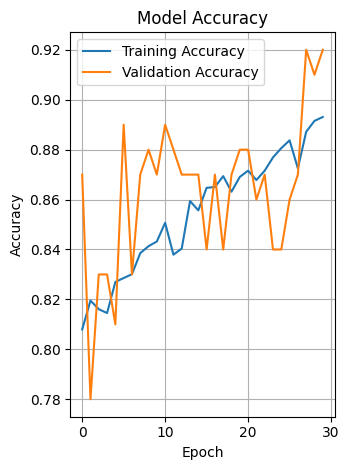

In [19]:


# Training Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.grid(True)

plt.tight_layout()
plt.show()


In [20]:
from tensorflow.keras.preprocessing import image
import numpy as np

def prepare_image(img_path, target_size=(150, 150)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0                 # Normalize if needed
    return img_array

# Path to the input image
img_path = r'train/AMERICAN BITTERN/002.jpg'

# Prepare the image
prepared_image = prepare_image(img_path)

# Make predictions
predictions = model.predict(prepared_image)
predicted_class = np.argmax(predictions, axis=1)

# Display the predicted class
class_labels = ['ABBOTTS BABBLER', 'ABBOTTS BOOBY', 'ABYSSINIAN GROUND HORNBILL', 'AFRICAN CROWNED CRANE', 'AFRICAN EMERALD CUCKOO',
                 'AFRICAN FIREFINCH', 'AFRICAN OYSTER CATCHER', 'AFRICAN PIED HORNBILL', 'AFRICAN PYGMY GOOSE', 'ALBATROSS',
                 'ALBERTS TOWHEE', 'ALEXANDRINE PARAKEET', 'ALPINE CHOUGH', 'ALTAMIRA YELLOWTHROAT', 'AMERICAN AVOCET',
                 'AMERICAN BITTERN', 'AMERICAN COOT', 'AMERICAN FLAMINGO', 'AMERICAN GOLDFINCH', 'AMERICAN GOLDFINCH']

predicted_label = class_labels[predicted_class[0]]
print(f'The predicted class is: {predicted_label}')


1/1 [==============================] - 0s 111ms/step
The predicted class is: AMERICAN BITTERN


In [1]:
import gradio as gr
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the saved model
model_path = 'model86.h5'
model = tf.keras.models.load_model(model_path)

# Define the class labels
class_labels = ['ABBOTTS BABBLER', 'ABBOTTS BOOBY', 'ABYSSINIAN GROUND HORNBILL', 'AFRICAN CROWNED CRANE', 'AFRICAN EMERALD CUCKOO',
                 'AFRICAN FIREFINCH', 'AFRICAN OYSTER CATCHER', 'AFRICAN PIED HORNBILL', 'AFRICAN PYGMY GOOSE', 'ALBATROSS',
                 'ALBERTS TOWHEE', 'ALEXANDRINE PARAKEET', 'ALPINE CHOUGH', 'ALTAMIRA YELLOWTHROAT', 'AMERICAN AVOCET',
                 'AMERICAN BITTERN', 'AMERICAN COOT', 'AMERICAN FLAMINGO', 'AMERICAN GOLDFINCH', 'AMERICAN GOLDFINCH']

def prepare_image(img):
    img = image.load_img(img, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0                 # Normalize if needed
    return img_array

def predict_image(img):
    prepared_image = prepare_image(img)
    predictions = model.predict(prepared_image)
    predicted_class = np.argmax(predictions, axis=1)
    predicted_label = class_labels[predicted_class[0]]
    return predicted_label

# Create the Gradio interface
iface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="filepath"),
    outputs=gr.Textbox(),
    title="Bird Species Classifier",
    description="Upload an image of a bird to classify it into one of the 20 species."
)

# Launch the app
iface.launch()





Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 0s 163ms/step
